### Fifth Notebook :bert embedding + BiLSTM + Attention-based + Context-aware

In [2]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.layers import *
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import matplotlib

In [3]:
train_df = pd.read_csv('../Datasets/MRDA/mrda_data/train_set.txt', sep='|')
val_df = pd.read_csv('../Datasets/MRDA/mrda_data/val_set.txt', sep='|')
test_df = pd.read_csv('../Datasets/MRDA/mrda_data/test_set.txt', sep='|')

train_df.columns=['Speaker','Utterances','Basic','General','Full']
val_df.columns=['Speaker','Utterances','Basic','General','Full']
test_df.columns=['Speaker','Utterances','Basic','General','Full']

In [4]:
x_train = train_df['Utterances'].to_numpy()
x_train = np.asarray(x_train).astype(str)
y_train = pd.get_dummies(train_df['Basic']).values
y_train = np.asarray(y_train).astype('float32')

x_val = val_df['Utterances'].to_numpy()
x_val = np.asarray(x_val).astype(str)
y_val = pd.get_dummies(val_df['Basic']).values
y_val = np.asarray(y_val).astype('float32')

x_test = test_df['Utterances'].to_numpy()
x_test = np.asarray(x_test).astype(str)
y_test = pd.get_dummies(test_df['Basic']).values
y_test = np.asarray(y_test).astype('float32')

In [5]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [6]:
### Self Attention layer
from keras import layers
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

In [7]:
### Hyperparameters
embed_dim = 128
num_heads = 5
ff_dim = 32

In [8]:
### Bert encoding layers
text_input = Input(shape=(),dtype=tf.string,name='Text')
preprocess_text = bert_preprocess(text_input)
encode_output = bert_encoder(preprocess_text)['encoder_outputs'][11]#output of the last encoded layer

### bilstm
bilstm = Bidirectional(LSTM(
    units=64,
    dropout=0.2,
    return_sequences=True))(encode_output)

### Attention layer
att = TransformerBlock(embed_dim, num_heads, ff_dim)(bilstm)
pool = GlobalAveragePooling1D()(att)

###Output
output = Dense(5,activation='softmax')(pool)

In [9]:
model=keras.Model(text_input,output)

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['Text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [12]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               mode='auto', 
                                               patience=3, 
                                               verbose=1)

In [ ]:
hist = model.fit(x_train, y_train, 
          epochs=100, 
          batch_size=32, 
          verbose=1,
          callbacks=[early_stopping],
          validation_data=(x_val, y_val))

Epoch 1/100
2346/2346 [==============================] - 2010s 857ms/step - loss: 0.2659 - accuracy: 0.8972 - val_loss: 0.2698 - val_accuracy: 0.8995
Epoch 2/100
2346/2346 [==============================] - 2035s 867ms/step - loss: 0.2607 - accuracy: 0.8986 - val_loss: 0.2621 - val_accuracy: 0.8960
Epoch 3/100
2346/2346 [==============================] - 2033s 867ms/step - loss: 0.2563 - accuracy: 0.8998 - val_loss: 0.2704 - val_accuracy: 0.8937
Epoch 4/100
2346/2346 [==============================] - 2032s 866ms/step - loss: 0.2527 - accuracy: 0.9010 - val_loss: 0.2567 - val_accuracy: 0.9005
Epoch 5/100
2346/2346 [==============================] - 2029s 865ms/step - loss: 0.2500 - accuracy: 0.9025 - val_loss: 0.2711 - val_accuracy: 0.8999
Epoch 6/100
2346/2346 [==============================] - 2028s 864ms/step - loss: 0.2472 - accuracy: 0.9024 - val_loss: 0.2597 - val_accuracy: 0.8997
Epoch 7/100
2346/2346 [==============================] - 2031s 866ms/step - loss: 0.2451 - accuracy:

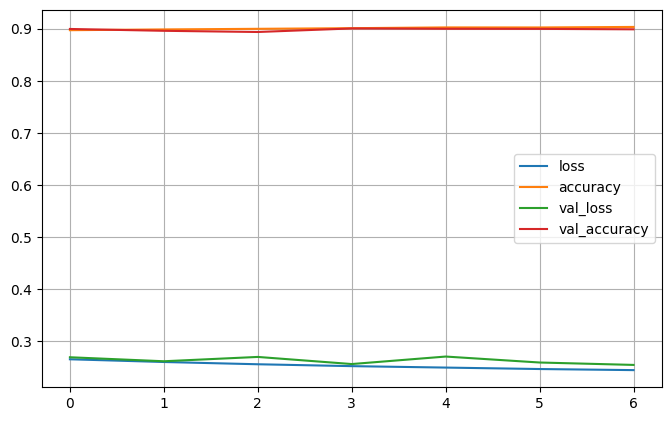

In [ ]:
matplotlib.rcParams['figure.dpi'] = 100

def plot(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()
    
plot(hist)

In [ ]:
model.evaluate(x_test, y_test)

514/514 [==============================] - 345s 670ms/step - loss: 0.3465 - accuracy: 0.8802


[0.3464691936969757, 0.880172848701477]

In [14]:
print('The model accuracy is : 0.88')

The model accuracy is : 0.88


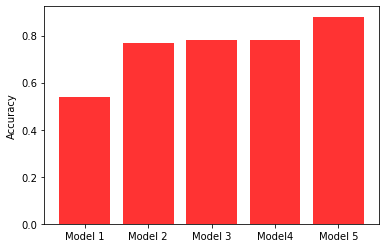

In [19]:
models=('Model 1', 'Model 2','Model 3','Model4','Model 5')
y_pos = np.arange(len(models))
accuracy=[0.54,0.77,0.78,0.78,0.88]
plt.bar(y_pos, accuracy, align='center', alpha=0.8, color='red')
plt.xticks(y_pos, models)
plt.ylabel('Accuracy')
plt.show()